# Data Challenge 

### GW Open Data Workshop

In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

In [2]:
import bilby
import numpy as np
from scipy.signal import find_peaks
from pycbc import frame
from pycbc.waveform import get_td_waveform
from gwpy.timeseries import TimeSeries
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.filter import matched_filter
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.figsize": (8, 6),
    "axes.unicode_minus": False,
})

Challenge activity for the Open Data Workshop course.

Data files may be downloaded from [DCC G2300818](https://dcc.ligo.org/LIGO-G2300818/public) using these links:

* [challenge1.gwf](https://dcc.ligo.org/public/0187/G2300818/001/challenge1.gwf)
* [challenge2.gwf](https://dcc.ligo.org/public/0187/G2300818/001/challenge2.gwf)
* [challenge3.gwf](https://dcc.ligo.org/public/0187/G2300818/001/challenge3.gwf)
* [challenge3_2048hz.gwf](https://dcc.ligo.org/public/0187/G2300818/001/challenge3_2048hz.gwf)   <-- Downsampled version of Challenge 3 file

Workshop participants may [submit solutions via thinkific](https://learn.gwosc.org) as individuals or in teams of up to 3 people.
Check for the deadline date on the Thinkific website.

Challenges are ordered by difficulty. Entries will be rewarded a number of
points that scales with the difficulty of the challenge. 

Good luck to all!

## Challenge 1 (1 point) -- Novice

Identify a loud binary black hole signal in white, Gaussian noise.

* Use the data file `challenge1.gwf`. The channel name is `H1:CHALLENGE1`.
* The data are white, Gaussian noise containing a simulated BBH signal.

1. Load the data into memory. What are the sampling rate and duration of the data?

In [4]:
strain = frame.read_frame('Challenge/challenge1.gwf', 'H1:CHALLENGE1')
strain = TimeSeries.from_pycbc(strain)
print('Sampling rate:', strain.sample_rate)
print('Duration:', strain.duration)

Sampling rate: 4096.0 Hz
Duration: 128.0 s


2. Plot the data in the time-domain. 

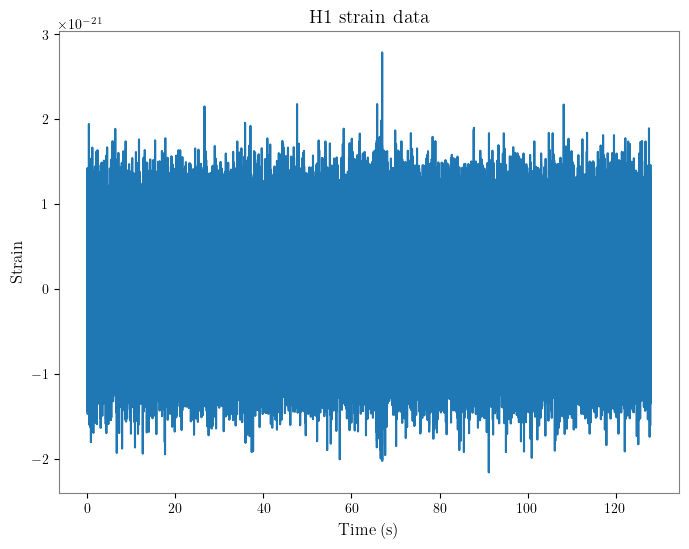

In [5]:
plt.plot(strain.times, strain)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('H1 strain data')
plt.grid()
plt.show()

3. Plot a spectrogram (or q-transform) of the data, and try to identify the signal.

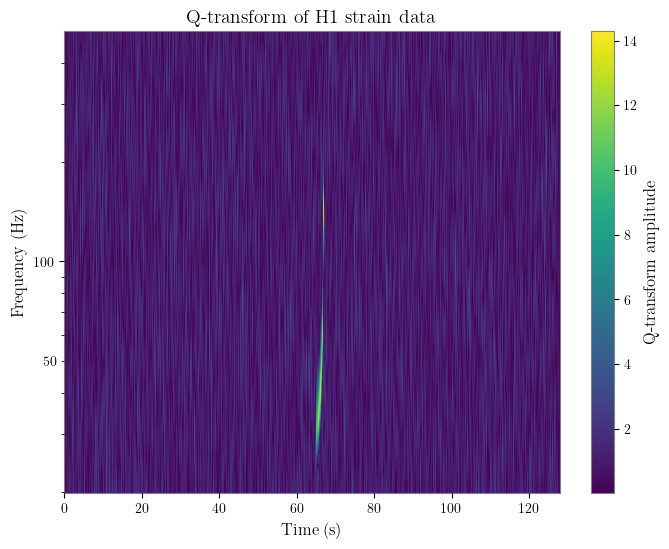

In [6]:
q = strain.q_transform(frange=(20, 500), qrange=(4, 12)).abs()**.5
plt.pcolormesh(q.times.value, q.frequencies.value, q.value.T)
plt.colorbar(label='Q-transform amplitude')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('Q-transform of H1 strain data')
plt.grid()
plt.yscale('log')
plt.show()

4. What is the time of the merger?

In [7]:
max_idx = np.unravel_index(np.argmax(q.value), q.value.shape)
merger_time_estimated = q.times[max_idx[0]]
print("Estimated merger time:", merger_time_estimated)

Estimated merger time: 66.816 s


## Challenge 2 (2 points) -- Rookie

Signal in colored, Gaussian noise.

* Use the data file `challenge2.gwf`, with channel name `H1:CHALLENGE2`.
* The data contain a BBH signal with m1 = m2 = 30 solar masses, spin = 0.

In [ ]:
strain = frame.read_frame('Challenge/challenge2.gwf', 'H1:CHALLENGE2')
strain = TimeSeries.from_pycbc(strain)

1. What is the approximative time of the merger? (Hint: a plot of the q-transform could help)

In [ ]:
q = strain.q_transform(frange=(20, 500), qrange=(4, 12)).abs()**.5
plt.pcolormesh(q.times.value, q.frequencies.value, q.value.T)
plt.colorbar(label='Q-transform amplitude')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('Q-transform of H1 strain data')
plt.grid()
plt.yscale('log')
plt.show()

2. Generate a time-domain template waveform using approximate `SEOBNRv4_opt`.
   with the same parameters as above. Plot this waveform.

In [ ]:
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
            mass1=30,
            mass2=30,
            delta_t=strain._dx.value,
            f_lower=20)

plt.plot(hp.sample_times, hp)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('H1 strain data')
plt.grid()
plt.show()

3. Calculate a PSD of the data, and plot this on a log-log scale.
   Use axes ranging from 20 Hz up to the Nyquist frequency.

In [ ]:
psd = strain.psd()
plt.plot(psd.frequencies, psd)
plt.xlabel('Time (s)')
plt.ylabel('Power spectral density')
plt.title('H1 strain data PSD') 
plt.grid()
plt.yscale('log')
plt.xlim(20, 512)
plt.show()

4. Use the template waveform and PSD to calculate the SNR time series. Plot the SNR time-series.

In [ ]:
strain = TimeSeries.to_pycbc(strain)

strain = highpass(strain, 15.0)
strain = resample_to_delta_t(strain, hp.delta_t)
conditioned = strain.crop(2, 2)

psd = conditioned.psd(4)
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate), low_frequency_cutoff=15)

hp.resize(len(conditioned))
template = hp.cyclic_time_shift(hp.start_time)

snr = matched_filter(template, conditioned, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4)

plt.plot(snr.sample_times, abs(snr))
plt.xlabel('Time (s)')
plt.ylabel('SNR')
plt.title('Matched filter SNR')
plt.grid()
plt.show()

5. What is the matched filter SNR of the signal?

In [ ]:
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print('Time of merger:', time)
print('SNR:', abs(snrp))

### Challenge 3 (4 points) -- Intermediate

* Use the data file `challenge3.gwf` with channel `H1:CHALLENGE3`.
* These are real LIGO data from O2, though we've adjusted the time labels and 
  added some simulated signals.
* The data contain a loud simulated signal with m1 = m2 = 10 solar masses.

In [ ]:
strain = frame.read_frame('Challenge/challenge3.gwf', 'H1:CHALLENGE3')
strain = TimeSeries.from_pycbc(strain)

1. What is the merger time of this signal?
2. What is the matched-filter SNR of this signal?

In [ ]:
q = strain.q_transform(frange=(20, 500), qrange=(4, 12)).abs()**.5
plt.pcolormesh(q.times.value, q.frequencies.value, q.value.T)
plt.colorbar(label='Q-transform amplitude')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('Q-transform of H1 strain data')
plt.grid()
plt.yscale('log')
plt.show()

In [ ]:
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
            mass1=10,
            mass2=10,
            delta_t=strain._dx.value,
            f_lower=20)

plt.plot(hp.sample_times, hp)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('H1 strain data')
plt.grid()
plt.show()

In [ ]:
psd = strain.psd()
plt.plot(psd.frequencies, psd)
plt.xlabel('Time (s)')
plt.ylabel('Power spectral density')
plt.title('H1 strain data PSD') 
plt.grid()
plt.yscale('log')
plt.xlim(20, 512)
plt.show()

In [ ]:
strain = TimeSeries.to_pycbc(strain)

strain = highpass(strain, 15.0)
strain = resample_to_delta_t(strain, hp.delta_t)
conditioned = strain.crop(2, 2)

psd = conditioned.psd(4)
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate), low_frequency_cutoff=15)

hp.resize(len(conditioned))
template = hp.cyclic_time_shift(hp.start_time)

snr = matched_filter(template, conditioned, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4)

plt.plot(snr.sample_times, abs(snr))
plt.xlabel('Time (s)')
plt.ylabel('SNR')
plt.title('Matched filter SNR')
plt.grid()
plt.show()

In [ ]:
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print('Time of merger:', time)
print('SNR:', abs(snrp))

### Challenge 4 (8 points) -- Advanced

* Use the data file `challenge3.gwf` with channels `H1:CHALLENGE3` and `L1:CHALLENGE3`.
* These are real LIGO data from O2, though we've adjusted the time labels and 
  added some simulated signals.
* Any simulated signals have been added to both the H1 and L1 data
* All simulated signals have spin = 0 and m1 = m2, with m1 somewhere in the range 10-50 solar masses

1. Identify as many signals as you can. Watch out! These are real data, and so glitches may be
present. Any correct detection is +1 point but any false alarms will count -1 point
against your score. For each signal you find, list:

 * The merger time
 * The SNR
 * Your estimate of the component masses

In [ ]:
strain_H1 = frame.read_frame('Challenge/challenge3_2048hz.gwf', 'H1:CHALLENGE3')
strain_L1 = frame.read_frame('Challenge/challenge3_2048hz.gwf', 'L1:CHALLENGE3')
strains = {'H1': strain_H1, 'L1': strain_L1}

In [ ]:
snr_dict, time_dict = {}, {}
for strain, label in zip(strains.values(), strains.keys()):
    
    masses = np.linspace(10, 50, 5)
    snr_values, time_values = [], []

    conditioned_strain = highpass(strain, 15.0)
    conditioned = conditioned_strain.crop(2, 2)

    psd = conditioned.psd(4)
    psd = interpolate(psd, conditioned.delta_f)
    psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate), low_frequency_cutoff=15)

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    for m in masses:
        hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                                  mass1=int(m),
                                  mass2=int(m),
                                  delta_t=conditioned.delta_t,
                                  f_lower=20)

        hp.resize(len(conditioned))
        template = hp.cyclic_time_shift(hp.start_time)

        snr_series = matched_filter(template, conditioned, psd=psd, low_frequency_cutoff=20)
        snr_series = snr_series.crop(8, 8)

        threshold_value = 8
        peaks, _ = find_peaks(abs(snr_series), height=threshold_value)
        for idx in peaks:
            snr_values.append(abs(snr_series)[idx])
            time_values.append(snr_series.sample_times[idx])
        snr_dict[label] = snr_values
        time_dict[label] = time_values

        ax.plot(snr_series.sample_times, abs(snr_series), label=f'$m_1 = m_2 = {int(m)} \\ M_\\odot$', alpha=0.3)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('SNR')
        ax.set_title(f'Matched filter SNR for {label}')
        ax.grid()
        ax.legend()
        
    plt.tight_layout()
    plt.show()

In [ ]:
unique_time_dict = {}
unique_snr_dict = {}
threshold = 0.1
for label in time_dict:
    sort_idx = np.argsort(time_dict[label])
    times = np.array(time_dict[label])[sort_idx]
    snrs = np.array(snr_dict[label])[sort_idx]
    
    u_times, u_snrs = [], []
    time_0, snr_0 = times[0], snrs[0]
    for t, s in zip(times[1:], snrs[1:]):
        if t - time_0 < threshold:
            if s > snr_0:
                time_0 = t
                snr_0 = s
        else:
            u_times.append(time_0)
            u_snrs.append(snr_0)
            time_0, snr_0 = t, s  
    u_times.append(time_0)
    u_snrs.append(snr_0)
    
    unique_time_dict[label], unique_snr_dict[label] = u_times, u_snrs

plt.plot(unique_time_dict['H1'], unique_snr_dict['H1'], 'o', label='H1', color='r')
plt.plot(unique_time_dict['L1'], unique_snr_dict['L1'], 'o', label='L1', color='b')
for times in unique_time_dict['H1']:
    plt.axvline(x=times, color='r', linestyle='--', alpha=0.5)
for times in unique_time_dict['L1']:
    plt.axvline(x=times, color='b', linestyle='--', alpha=0.5)
plt.xlabel('Time (s)')
plt.ylabel('SNR')
plt.title('Matched filter SNR for H1 and L1')
plt.grid()
plt.legend()
plt.show()

In [ ]:
tol = 0.1
common_times = []
for t_H1 in unique_time_dict['H1']:
    for t_L1 in unique_time_dict['L1']:
        if abs(t_H1 - t_L1) < tol:
            common_times.append((t_H1 + t_L1)/2)
common_times = np.unique(common_times)

In [ ]:
for t_event in common_times:
    for strain, label in zip(strains.values(), strains.keys()):
        seg = strain.crop(t_event-4, strain.end_time-t_event-4)
        plt.plot(seg.sample_times, seg)
        plt.xlabel('Time (s)')
        plt.ylabel('Strain')
        plt.title(f'{label} strain data')
        plt.grid()
        plt.show()

In [ ]:
for t_event in common_times:
    for strain, label in zip(strains.values(), strains.keys()):
        seg = strain.crop(t_event-4, strain.end_time-t_event-4)
        seg = TimeSeries.from_pycbc(seg)
        q = seg.q_transform(frange=(20, 500), qrange=(4, 12)).abs()**.5
        plt.pcolormesh(q.times.value, q.frequencies.value, q.value.T)
        plt.colorbar(label='Q-transform amplitude')
        plt.ylabel('Frequency (Hz)')
        plt.xlabel('Time (s)')
        plt.title(f'Q-transform of {label} strain data')
        plt.grid()
        plt.yscale('log')
        plt.show()

In [ ]:
fit_results = []
for t_event in common_times:
    for strain, label in zip(strains.values(), strains.keys()):
        seg = strain.crop(t_event-4, strain.end_time-t_event-4)
        seg_cond = highpass(seg, 15.0)
    
        psd = strain.psd(4)
        psd_seg = interpolate(psd, seg_cond.delta_f)
        psd_seg = inverse_spectrum_truncation(psd_seg, int(4 * strain.sample_rate), low_frequency_cutoff=15)
        
        masses = np.linspace(10, 50, 21)
        snr_val, mass, template = 0, None, None
        
        for m in masses:
            hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                                  mass1=int(m),
                                  mass2=int(m),
                                  delta_t=seg_cond.delta_t,
                                  f_lower=20)

            hp.resize(len(seg_cond))
            temp = hp.cyclic_time_shift(hp.start_time)

            snr_series = matched_filter(temp, seg_cond, psd=psd_seg, low_frequency_cutoff=20)
            snr_series = snr_series.crop(2, 2)

            snr_peak = abs(snr_series.at_time(t_event))
            if snr_peak > snr_val:
                snr_val, mass, template = snr_peak, m, hp
        
        print(f"For event at t ~ {t_event} in {label} strain data, best-fit mass: {mass}, SNR: {snr_val} in {label} strain data")
        fit_results.append((t_event, mass, snr_val))

        plt.plot(snr_series.sample_times, abs(snr_series))
        plt.xlabel('Time (s)')
        plt.ylabel('SNR')
        plt.title(f'Matched filter SNR for {label} with mass ${mass}\\ M_\\odot$')
        plt.grid()
        plt.show()

        plt.plot(seg_cond.sample_times, seg_cond, label='Strain', alpha=0.5)
        template.start_time = seg_cond.start_time
        plt.plot(template.sample_times, template, label='Template', alpha=0.5)
        plt.xlabel('Time (s)')
        plt.ylabel('Strain')
        plt.title(f'{label} strain data and template')
        plt.grid()
        plt.legend(['Strain', 'Template'])
        plt.show()

2. Identify as many glitches as you can. Make a spectrogram of each one.

In [ ]:
uncommon_times = {}
for label in unique_time_dict:
    uncommon_times[label] = []
    for t in unique_time_dict[label]:
        if label == 'H1':
            if not np.isclose(t, common_times, atol=0.1).any():
                uncommon_times[label].append(t)
        else:
            if not np.isclose(t, common_times, atol=0.1).any():
                uncommon_times[label].append(t)

In [ ]:
for label in uncommon_times:
    strain_channel = strains[label]
    for t_event in uncommon_times[label]:
        print(f"Glitch in {label} strain data: {t_event}")
        seg = strain.crop(t_event-1, strain.end_time-t_event-1)
        seg = TimeSeries.from_pycbc(seg)
        q = seg.q_transform(frange=(20, 500), qrange=(4, 12)).abs()**.5
        plt.pcolormesh(q.times.value, q.frequencies.value, q.value.T)
        plt.colorbar(label='Q-transform amplitude')
        plt.ylabel('Frequency (Hz)')
        plt.xlabel('Time (s)')
        plt.title(f'Q-transform of {label} strain data')
        plt.grid()
        plt.yscale('log')
        plt.show()

3. For each simulated BBH you found, use bilby to compute a posterior
   distribution for the mass. You can fix the spin and mass ratio to make
   this run faster.

In [ ]:
sampling_rate = 2048
duration = 8

In [ ]:
posterior_results = {}
for t_event in common_times:
    print(f"Running PE for event at t = {t_event:.2f} s")
    
    start_time = t_event - 4
    seg = strain.crop(t_event-4, strain.end_time-t_event-4)
    seg = TimeSeries.from_pycbc(seg)

    interferometers = bilby.gw.detector.InterferometerList([])
    for ifo_name in ['H1', 'L1']:
        ifo = bilby.gw.detector.get_empty_interferometer(ifo_name)
        ifo.set_strain_data_from_power_spectral_density(
            sampling_frequency=sampling_rate, start_time=start_time, duration=duration,
        )
        ifo.set_strain_data_from_gwpy_timeseries(seg)
        interferometers.append(ifo)

    prior = bilby.core.prior.PriorDict()
    prior['mass_1'] = bilby.core.prior.Uniform(10, 50, name='mass_1', latex_label='$m_1$', unit='$M_\\odot$')
    prior['mass_ratio'] = 1
    prior['phase'] = bilby.core.prior.Uniform(0, 2 * np.pi, name='phase', latex_label='$\\phi$', unit='rad')
    prior['geocent_time'] = bilby.core.prior.Uniform(t_event - 0.1, t_event + 0.1, name='geocent_time', latex_label='$t_c$', unit='s')
    prior['a_1'] =  0.0
    prior['a_2'] =  0.0
    prior['tilt_1'] =  0.0
    prior['tilt_2'] =  0.0
    prior['phi_12'] =  0.0
    prior['phi_jl'] =  0.0
    prior['dec'] =  -1.2232
    prior['ra'] =  2.19432
    prior['theta_jn'] =  1.89694
    prior['psi'] =  0.532268
    prior['luminosity_distance'] = bilby.core.prior.PowerLaw(alpha=2, name='luminosity_distance', minimum=50, maximum=2000, unit='Mpc', latex_label='$d_L$')

    waveform_arguments = dict(
        waveform_approximant='SEOBNRv4_opt', reference_frequency=100., catch_waveform_errors=True)

    waveform_generator = bilby.gw.WaveformGenerator(
        frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
        waveform_arguments=waveform_arguments,
        parameter_conversion=convert_to_lal_binary_black_hole_parameters)

    likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
        interferometers, waveform_generator, priors=prior,
        time_marginalization=True, phase_marginalization=True, distance_marginalization=True)
    
    result = bilby.run_sampler(
        likelihood=likelihood,
        priors=prior,
        sampler='dynesty',
        nlive=250, dlogz=1.,
        outdir='Challenge/bilby_results',
        label=f"PE_event_{int(t_event)}",
        verbose=True
    )
    
    posterior_results[t_event] = result.posterior